In [1]:
# Load the preprocessed dataset
with open("../data/processed/don_quixote.txt", "r", encoding="utf-8") as file:
    words = file.read().split()
print(f"Total words in dataset: {len(words)}")

Total words in dataset: 427413


We'll start by performing a single run through the text, and plotting the number of unique words (vocabulary size) against the total number of words processed. This will help us visualize Heaps' Law.

In [ ]:
from typing import List
import numpy as np


def analyze_vocabulary_growth(words: List[str]):
    vocab = set()
    words_processed = np.arange(1, len(words) + 1, dtype=np.uint32)
    vocab_sizes = np.zeros(len(words), dtype=np.uint32)
    for i, word in enumerate(words):
        vocab.add(word)
        vocab_sizes[i] = len(vocab)

    return words_processed, vocab_sizes, vocab


words_processed, vocab_sizes, _ = analyze_vocabulary_growth(words)

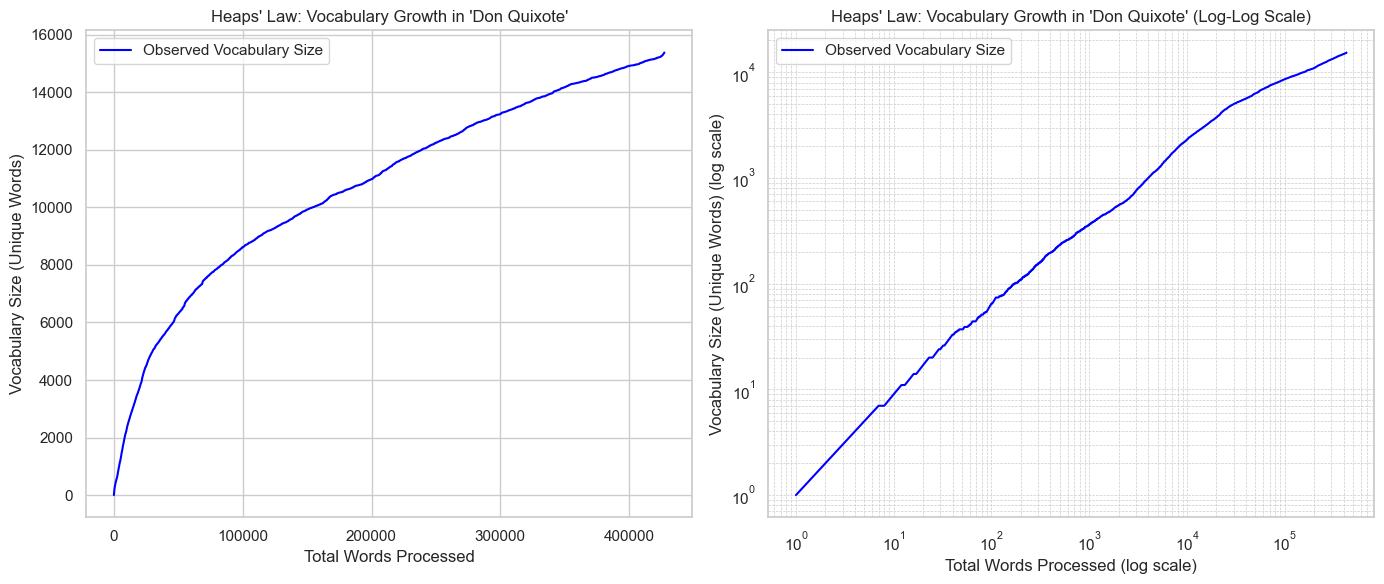

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")


fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# First figure: Linear scale
ax[0].plot(words_processed, vocab_sizes, label="Observed Vocabulary Size", color="blue")
ax[0].set_xlabel("Total Words Processed")
ax[0].set_ylabel("Vocabulary Size (Unique Words)")
ax[0].set_title("Heaps' Law: Vocabulary Growth in 'Don Quixote'")
ax[0].legend()

# Axis 2: Log-Log Scale
ax[1].grid(True, which="both", linestyle="--", linewidth=0.5)  # Add grid for better readability
ax[1].loglog(words_processed, vocab_sizes, label="Observed Vocabulary Size", color="blue")
ax[1].set_xlabel("Total Words Processed (log scale)")
ax[1].set_ylabel("Vocabulary Size (Unique Words) (log scale)")
ax[1].set_title("Heaps' Law: Vocabulary Growth in 'Don Quixote' (Log-Log Scale)")
ax[1].legend()

plt.tight_layout()
plt.show()

We'll try to fit two models to the data:

#### A linear model over the logarithms of the two variables

Provided that
$$
    V(n) \propto n^{\beta} \Longrightarrow V(n) = K n^{\beta} 
$$
where, trivially, V(0) = 0, then we can take logarithms on both sides to get:
$$
    \log(V(n)) = \log(K) + \beta \log(n)
$$

In [4]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(np.log(words_processed).reshape(-1, 1), np.log(vocab_sizes).reshape(-1, 1))
beta_ols = model.coef_[0][0]
K_ols = np.exp(model.intercept_[0])
print(f"Fitted parameters: K = {K_ols:.4f}, beta = {beta_ols:.4f}")

Fitted parameters: K = 23.5100, beta = 0.5050


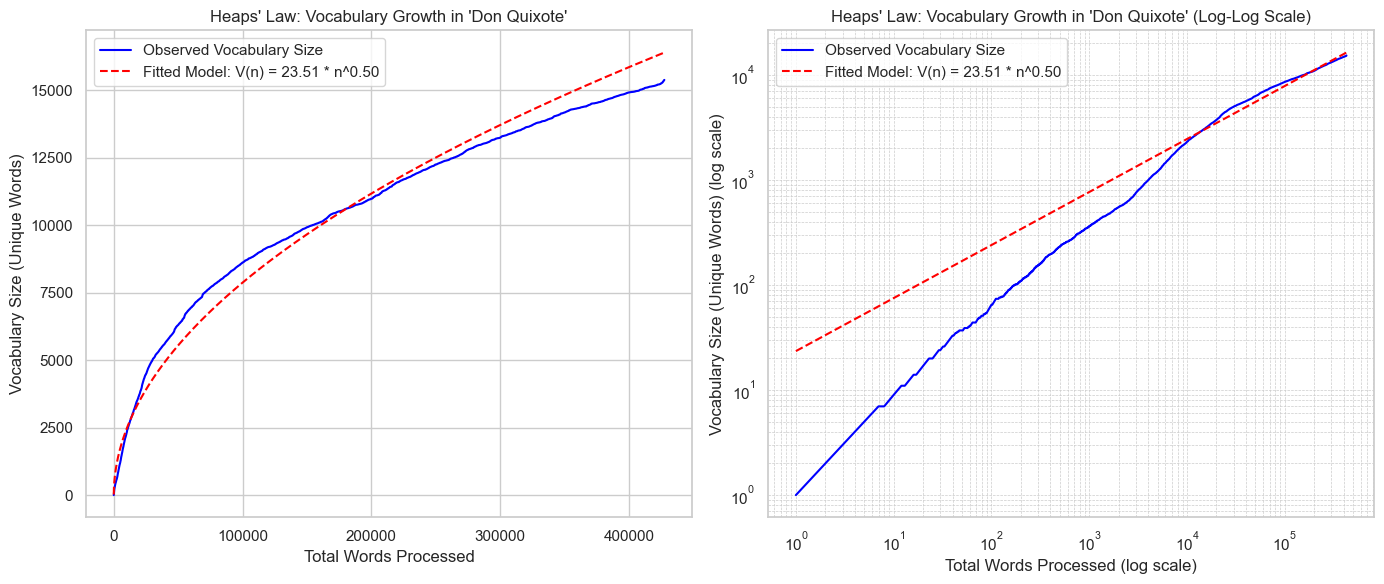

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# First figure: Linear scale
ax[0].plot(words_processed, vocab_sizes, label="Observed Vocabulary Size", color="blue")
ax[0].plot(
    words_processed,
    K_ols * words_processed**beta_ols,
    label=f"Fitted Model: V(n) = {K_ols:.2f} * n^{beta_ols:.2f}",
    color="red",
    linestyle="--",
)
ax[0].set_xlabel("Total Words Processed")
ax[0].set_ylabel("Vocabulary Size (Unique Words)")
ax[0].set_title("Heaps' Law: Vocabulary Growth in 'Don Quixote'")
ax[0].legend()

# Axis 2: Log-Log Scale
ax[1].grid(True, which="both", linestyle="--", linewidth=0.5)  # Add grid for better readability
ax[1].loglog(words_processed, vocab_sizes, label="Observed Vocabulary Size", color="blue")
ax[1].loglog(
    words_processed,
    K_ols * words_processed**beta_ols,
    label=f"Fitted Model: V(n) = {K_ols:.2f} * n^{beta_ols:.2f}",
    color="red",
    linestyle="--",
)
ax[1].set_xlabel("Total Words Processed (log scale)")
ax[1].set_ylabel("Vocabulary Size (Unique Words) (log scale)")
ax[1].set_title("Heaps' Law: Vocabulary Growth in 'Don Quixote' (Log-Log Scale)")
ax[1].legend()

plt.tight_layout()
plt.show()

#### A power law model

The issue with the above model, is that the transformation of the variables (taking logarithms) can distort the error structure of the data, which the ordinary least squares (OLS) method of linear regressions assumes to be normally distributed and homoscedastic (i.e., having constant variance).

To avoid this problem, we can fit the original power law model directly to the data using non-linear least squares (NLS). This method minimizes the sum of squared differences between the observed values and the values predicted by the model, without transforming the variables. 

This approach still requires both assumptions to be met. The first one (normality of errors) can be assumed by the Central Limit Theorem, given a sufficiently large sample size. The second one (homoscedasticity) should be checked, but not enough data points are available to do so reliably.

In [6]:
from scipy.optimize import curve_fit


def func_power_law(x: float, beta: float, K: float) -> float:
    return K * x**beta


print(f"Starting a fit from the OLS result (K = {K_ols:.4f}, beta = {beta_ols:.4f})")
(beta_curve_fit, K_curve_fit), pcov = curve_fit(func_power_law, words_processed, vocab_sizes, p0=[beta_ols, K_ols])
print(f"Curve fit parameters: K = {K_curve_fit:.4f}, beta = {beta_curve_fit:.4f}")
print(f"Covariance matrix:\n{pcov}")

Starting a fit from the OLS result (K = 23.5100, beta = 0.5050)
Curve fit parameters: K = 63.8881, beta = 0.4230
Covariance matrix:
[[ 3.05664186e-09 -2.42611372e-06]
 [-2.42611372e-06  1.92931316e-03]]


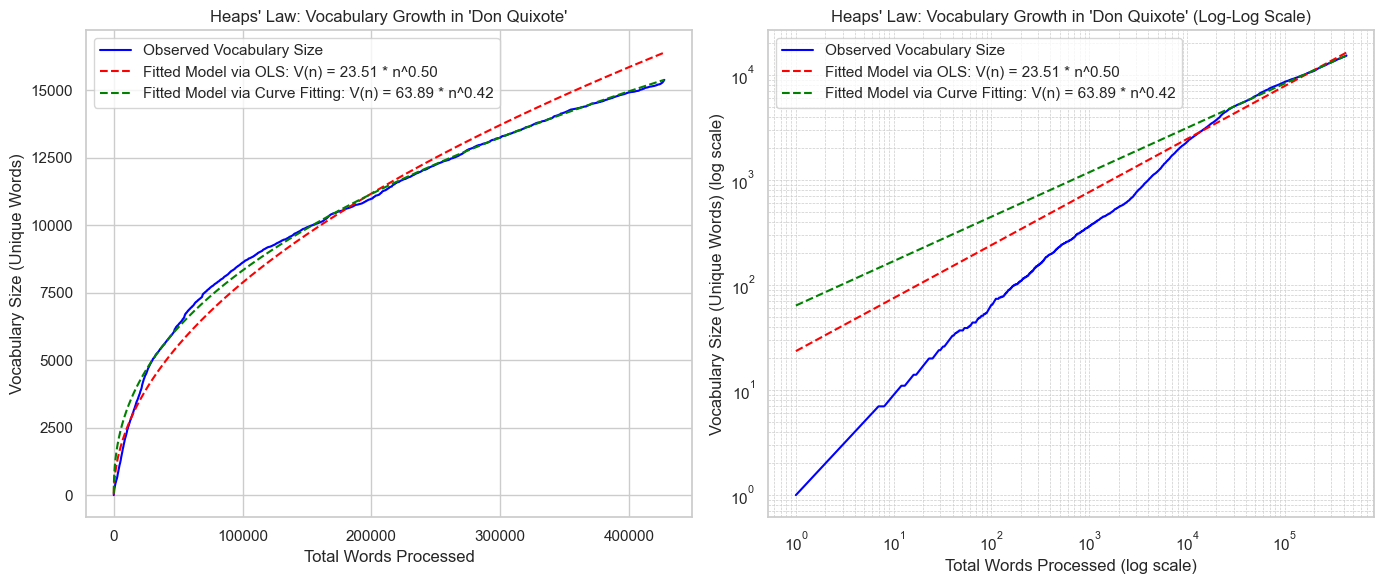

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# First figure: Linear scale
ax[0].plot(words_processed, vocab_sizes, label="Observed Vocabulary Size", color="blue")
ax[0].plot(
    words_processed,
    K_ols * words_processed**beta_ols,
    label=f"Fitted Model via OLS: V(n) = {K_ols:.2f} * n^{beta_ols:.2f}",
    color="red",
    linestyle="--",
)
ax[0].plot(
    words_processed,
    K_curve_fit * words_processed**beta_curve_fit,
    label=f"Fitted Model via Curve Fitting: V(n) = {K_curve_fit:.2f} * n^{beta_curve_fit:.2f}",
    color="green",
    linestyle="--",
)
ax[0].set_xlabel("Total Words Processed")
ax[0].set_ylabel("Vocabulary Size (Unique Words)")
ax[0].set_title("Heaps' Law: Vocabulary Growth in 'Don Quixote'")
ax[0].legend()

# Axis 2: Log-Log Scale
ax[1].grid(True, which="both", linestyle="--", linewidth=0.5)  # Add grid for better readability
ax[1].loglog(words_processed, vocab_sizes, label="Observed Vocabulary Size", color="blue")
ax[1].loglog(
    words_processed,
    K_ols * words_processed**beta_ols,
    label=f"Fitted Model via OLS: V(n) = {K_ols:.2f} * n^{beta_ols:.2f}",
    color="red",
    linestyle="--",
)
ax[1].loglog(
    words_processed,
    K_curve_fit * words_processed**beta_curve_fit,
    label=f"Fitted Model via Curve Fitting: V(n) = {K_curve_fit:.2f} * n^{beta_curve_fit:.2f}",
    color="green",
    linestyle="--",
)
ax[1].set_xlabel("Total Words Processed (log scale)")
ax[1].set_ylabel("Vocabulary Size (Unique Words) (log scale)")
ax[1].set_title("Heaps' Law: Vocabulary Growth in 'Don Quixote' (Log-Log Scale)")
ax[1].legend()

plt.tight_layout()
plt.show()

## Bootstrapping approaches

Now, we'll do a more interesting approach to the same problem. Instead of performing a simple "single run" through the text, we'll randomize the text order several times. This way, we can create multiple "bootstrapped" samples of our data and analyze the variability in the vocabulary growth patterns.

In [23]:
import random

random.seed(42)

num_bootstraps = 10
words_processed = np.empty(len(words) * num_bootstraps, dtype=np.uint32)
vocab_sizes = np.empty(len(words) * num_bootstraps, dtype=np.uint32)
print(f"Preparing {num_bootstraps} bootstrapped samples...")
for i in range(num_bootstraps):
    reordered_words = words.copy()
    random.shuffle(reordered_words)
    words_processed[i * len(words) : (i + 1) * len(words)], vocab_sizes[i * len(words) : (i + 1) * len(words)], _ = (
        analyze_vocabulary_growth(reordered_words)
    )

print(f"Generated {len(words_processed)} observations")

Preparing 10 bootstrapped samples...
Generated 4274130 observations


C:\Users\mirxm\AppData\Local\Temp\ipykernel_2984\1048632602.py:20: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


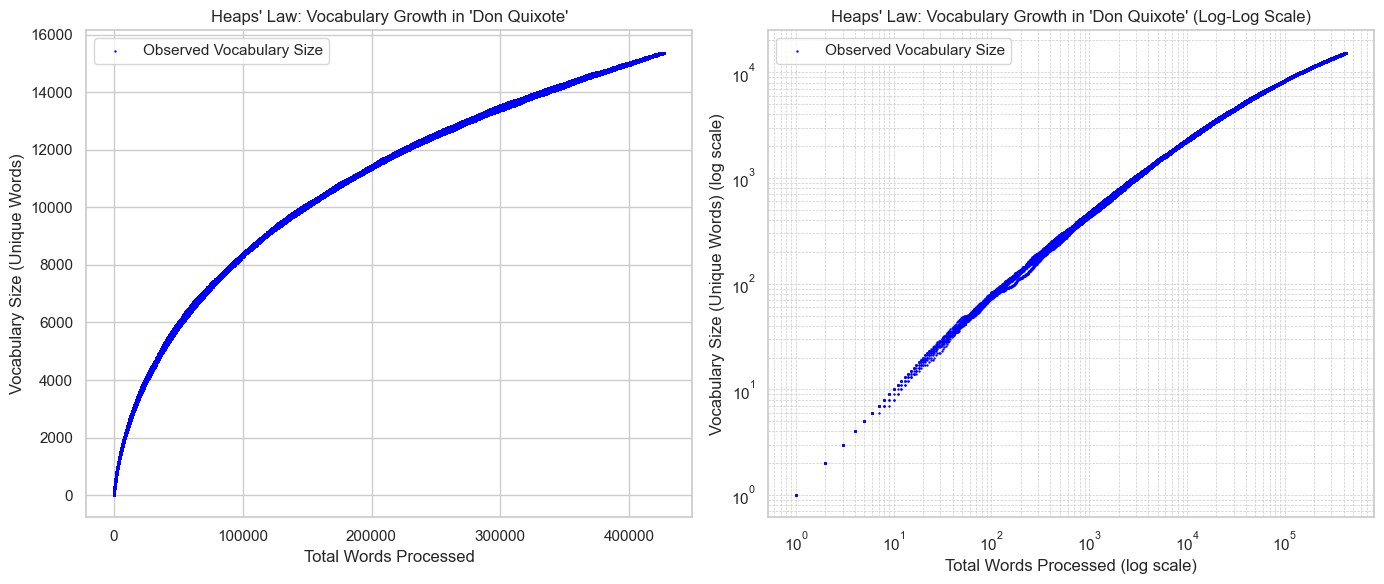

In [27]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# First figure: Linear scale
ax[0].scatter(words_processed, vocab_sizes, label="Observed Vocabulary Size", color="blue", s=0.5)
ax[0].set_xlabel("Total Words Processed")
ax[0].set_ylabel("Vocabulary Size (Unique Words)")
ax[0].set_title("Heaps' Law: Vocabulary Growth in 'Don Quixote'")
ax[0].legend()

# Axis 2: Log-Log Scale
ax[1].grid(True, which="both", linestyle="--", linewidth=0.5)  # Add grid for better readability
ax[1].scatter(words_processed, vocab_sizes, label="Observed Vocabulary Size", color="blue", s=0.5)
ax[1].set_xscale("log")
ax[1].set_yscale("log")
ax[1].set_xlabel("Total Words Processed (log scale)")
ax[1].set_ylabel("Vocabulary Size (Unique Words) (log scale)")
ax[1].set_title("Heaps' Law: Vocabulary Growth in 'Don Quixote' (Log-Log Scale)")
ax[1].legend()

plt.tight_layout()
plt.show()

In [29]:
model = LinearRegression()

print(f"Starting a linear regression on log-log data...")
model.fit(np.log(words_processed).reshape(-1, 1), np.log(vocab_sizes).reshape(-1, 1))
beta_ols = model.coef_[0][0]
K_ols = np.exp(model.intercept_[0])
print(f"Fitted parameters: K = {K_ols:.4f}, beta = {beta_ols:.4f}")

print(f"Starting a fit from the OLS result (K = {K_ols:.4f}, beta = {beta_ols:.4f})")
(beta_curve_fit, K_curve_fit), pcov = curve_fit(func_power_law, words_processed, vocab_sizes, p0=[beta_ols, K_ols])
print(f"Curve fit parameters: K = {K_curve_fit:.4f}, beta = {beta_curve_fit:.4f}")
print(f"Covariance matrix:\n{pcov}")

Starting a linear regression on log-log data...
Fitted parameters: K = 21.1946, beta = 0.5136
Starting a fit from the OLS result (K = 21.1946, beta = 0.5136)
Curve fit parameters: K = 48.9525, beta = 0.4451
Covariance matrix:
[[ 3.29972642e-10 -2.00886698e-07]
 [-2.00886698e-07  1.22520759e-04]]


C:\Users\mirxm\AppData\Local\Temp\ipykernel_2984\4255108793.py:49: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
c:\Users\mirxm\Storage\Work\MDS\S3\IRRS\MDS-IRRS-ZipfLaw\.venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


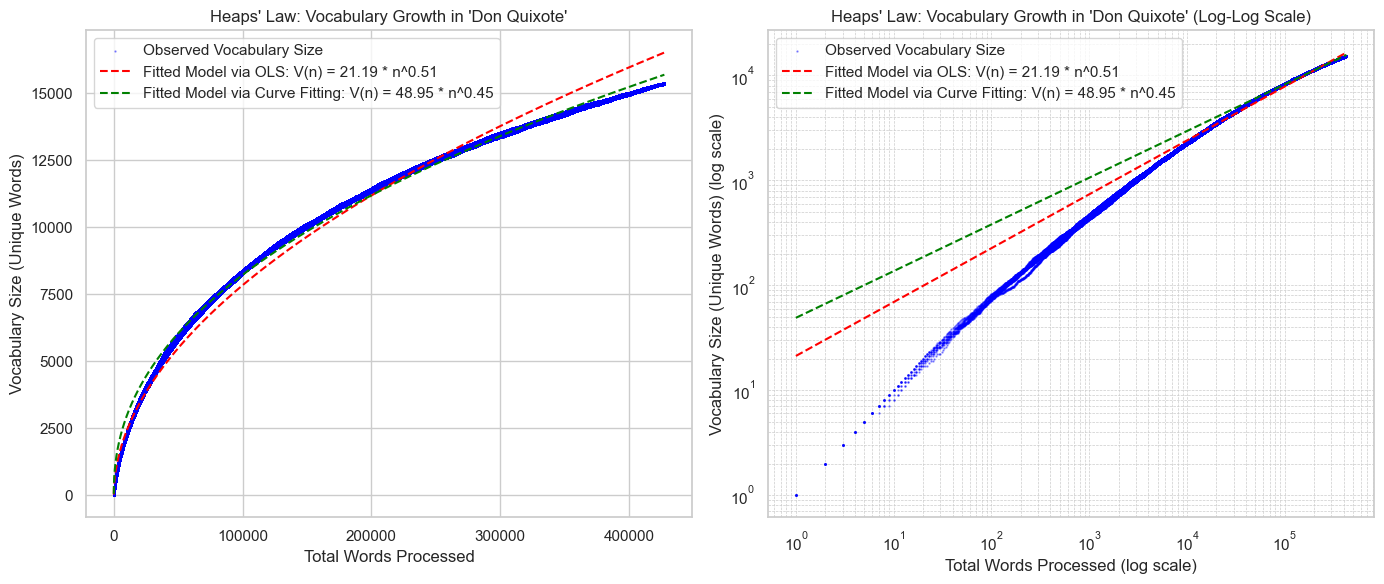

In [33]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
X = np.arange(1, len(words) + 1)

# First figure: Linear scale
ax[0].scatter(words_processed, vocab_sizes, label="Observed Vocabulary Size", color="blue", s=0.5, alpha=0.4)
ax[0].plot(
    X,
    K_ols * X**beta_ols,
    label=f"Fitted Model via OLS: V(n) = {K_ols:.2f} * n^{beta_ols:.2f}",
    color="red",
    linestyle="--",
)
ax[0].plot(
    X,
    K_curve_fit * X**beta_curve_fit,
    label=f"Fitted Model via Curve Fitting: V(n) = {K_curve_fit:.2f} * n^{beta_curve_fit:.2f}",
    color="green",
    linestyle="--",
)
ax[0].set_xlabel("Total Words Processed")
ax[0].set_ylabel("Vocabulary Size (Unique Words)")
ax[0].set_title("Heaps' Law: Vocabulary Growth in 'Don Quixote'")
ax[0].legend()

# Axis 2: Log-Log Scale
ax[1].grid(True, which="both", linestyle="--", linewidth=0.5)  # Add grid for better readability
ax[1].scatter(words_processed, vocab_sizes, label="Observed Vocabulary Size", color="blue", s=0.5, alpha=0.4)
ax[1].plot(
    X,
    K_ols * X**beta_ols,
    label=f"Fitted Model via OLS: V(n) = {K_ols:.2f} * n^{beta_ols:.2f}",
    color="red",
    linestyle="--",
)
ax[1].plot(
    X,
    K_curve_fit * X**beta_curve_fit,
    label=f"Fitted Model via Curve Fitting: V(n) = {K_curve_fit:.2f} * n^{beta_curve_fit:.2f}",
    color="green",
    linestyle="--",
)
ax[1].set_xscale("log")
ax[1].set_yscale("log")
ax[1].set_xlabel("Total Words Processed (log scale)")
ax[1].set_ylabel("Vocabulary Size (Unique Words) (log scale)")
ax[1].set_title("Heaps' Law: Vocabulary Growth in 'Don Quixote' (Log-Log Scale)")
ax[1].legend()

plt.tight_layout()
plt.show()